In [1]:
from utils import get_hyperedges, get_data, get_H, check_feasibility
from model import CustomLossBatch, utility_fn
from datagen import generate_data
from linsat import linsat_layer_modified
import torch
import time
import numpy as np
import pickle

# Pyomo Solver

In [2]:
# from pyomo.environ import (
#     ConcreteModel, Var, Objective, ConstraintList, SolverFactory, NonNegativeReals, Binary, maximize
# )
# # Step 2: Create Pyomo model
# model = ConcreteModel()

# # Step 3: Define binary decision variables for each link (b_i)
# model.b = Var(range(V_H), domain=Binary)  # b[i] = 1 if link i is active, 0 otherwise

# # Step 4: Define the objective function (maximize throughput)
# def throughput(model):
#     total_throughput = 0
#     for i in range(V_H):
#         interference = sum(model.b[j] * I[i, j] for j in range(V_H) if j != i)  # Interference from other active links
#         denominator = N[i] + interference  # Noise + interference
#         total_throughput += (I[i,i] * model.b[i]) / denominator  # Contribution of link i to throughput
#     return total_throughput

# model.obj = Objective(rule=throughput, sense=maximize)

# # Step 5: Add constraints for hyperedges (each hyperedge has a threshold)
# model.constraints = ConstraintList()

# for e_idx, hyperedge in enumerate(hyperedges):
#     model.constraints.add(
#         sum(model.b[i] for i in hyperedge) <= len(hyperedge)-1
#     )

# # Step 6: Solve the model
# solver = SolverFactory('ipopt')  # Use Ipopt for nonlinear problems
# result = solver.solve(model, tee=True)

# # Step 7: Extract the results
# optimal_decisions = [model.b[i].value for i in range(V_H)]

# # Output the optimal link schedule
# print("Optimal link schedule:", optimal_decisions)
# print("Maximum throughput:", model.obj())

# HyperDataset

**Run this before Loading Saved Data**

In [3]:
from torch.utils.data import Dataset, DataLoader

class HyperDataset(Dataset):
    def __init__(self, I, Dv_inv, De_inv, H, W):
        self.I = I
        self.Dv_inv = Dv_inv
        self.De_inv = De_inv
        self.H = H
        self.W = W

    def __len__(self):
        return len(self.I)

    def __getitem__(self, idx):
        return self.I[idx], self.Dv_inv[idx], self.De_inv[idx], self.H[idx], self.W[idx]


# Parameters

In [4]:
# Step 1: Define problem parameters
V_H = 10  # Number of nodes (links)
E_H = 5   # Number of hyperedges
# N = 0.1  # Noise power
N_db = -136.87  # dB
N = 10**(N_db/10)
theta = 10  # Thresholds for hyperedges
k = 5  # max hyperedge cardinality
train_samples = 1000
test_samples = 100
batch_size = 100

# Load Pre-Generated Data

**Use this data for result evaluation**</br>
<span style="color:cyan">**Skip Generate Data and Data Prepration If you are using this part**</span>

In [5]:
with open('train_dataset_n10_xylim4000.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
with open('test_dataset_n10_xylim4000.pkl', 'rb') as f:
    test_dataset = pickle.load(f)


# defining a data loader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Generate data

In [98]:
xy_lim = 4000
itens_train, hlist_train = get_data(train_samples, V_H, N, xy_lim, theta, k)
itens_test, hlist_test = get_data(test_samples, V_H, N, xy_lim, theta, k)
H_train = get_H(hlist_train, V_H, train_samples)
H_test = get_H(hlist_test, V_H, test_samples)

## Data Preparation

Format of Data Should be as follows
Dictionary Keys: "$n$": Number of hypernodes ($|\mathcal{V}_H|$), "$E$": dictionray of hyperedges, "$I \in R^{n\times n}$": Interference and Power matrix, "$H \in \{0,1\}^{n\times m}$: Incident matrix ($m$ is the size of hyperedges) 

In [99]:
def hypergraph_generation(V_H, I, hyperedges):
    hypergraph = {}

    

    hypergraph["I"] = torch.DoubleTensor(I)


    H = torch.DoubleTensor(hyperedges)
    Dv_inv = torch.diag(H.sum(0)**(-1/2))
    De_inv = torch.diag(H.sum(1)**(-1))
    W = torch.eye(V_H, dtype=torch.float64)
    hypergraph["H"] = H
    hypergraph["Dv_inv"] = Dv_inv
    hypergraph["De_inv"] = De_inv
    hypergraph["W"] = W
    return hypergraph

### Generating train and test dataste

In [100]:
hyps_train, hyps_test = [], []

Is = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Dv_invs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
De_invs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Hs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Ws = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)

i = 0
for I, hyperedges in zip(itens_train, H_train):
    hyp = hypergraph_generation(V_H, I, hyperedges)
    Is[i] = hyp["I"]
    Dv_invs[i] = hyp["Dv_inv"]
    De_invs[i] = hyp["De_inv"]
    Hs[i] = hyp["H"]
    Ws[i] = hyp["W"]
    i += 1

train_dataset = HyperDataset(Is, Dv_invs, De_invs, Hs, Ws)

Is = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Dv_invs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
De_invs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Hs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Ws = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)

i = 0
for I, hyperedges in zip(itens_test, H_test):
    hyp = hypergraph_generation(V_H, I, hyperedges)
    Is[i] = hyp["I"]
    Dv_invs[i] = hyp["Dv_inv"]
    De_invs[i] = hyp["De_inv"]
    Hs[i] = hyp["H"]
    Ws[i] = hyp["W"]
    i += 1

test_dataset = HyperDataset(Is, Dv_invs, De_invs, Hs, Ws)

In [6]:
# defining a data loader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Exhaustive Search Solver

In [7]:
# exhaustive search
def exh_solver(V_H, E_H, N, I, hyperedges):
    best_throughput = 0
    best_schedule = None
    for i in range(2**V_H):
        schedule = np.array([int(x) for x in bin(i)[2:].zfill(V_H)])  # Numpy is faster than torch
        throughput = 0
        # check if the schedule satisfies the hyperedge constraints
        valid_schedule = True
        for hyperedge in hyperedges:
            non_zero_idx = np.nonzero(hyperedge)[0]
            is_not_trivial = len(non_zero_idx) > 1
            if sum(schedule[non_zero_idx]) == len(non_zero_idx) and is_not_trivial:
                valid_schedule = False
                break
        
        if not valid_schedule:
            continue
        # calculate throughput
        for i in range(V_H):
            interference = sum(schedule[j] * I[i, j] for j in range(V_H) if j != i)
            denominator = N[i] + interference
            throughput += np.log2(1+(I[i,i] * schedule[i]) / denominator)
        # print(schedule, throughput)
        if throughput > best_throughput:
            best_throughput = throughput
            best_schedule = schedule

    return best_throughput, best_schedule
        

In [9]:
print("Exhaustive search results:")
best_throughput_test = []
for i, sample in enumerate(test_dataset):
    X, _, _, H, _ = sample
    best_throughput, best_schedule = exh_solver(X.shape[0], X.shape[0], X.shape[0]*[N], X.detach().numpy(), H.detach().numpy())
    best_throughput_test.append(best_throughput)
    # print("Optimal link schedule:", best_schedule)
    print("Optimal link schedule " , best_schedule, " Maximum throughput:", best_throughput, "bits/s/Hz")
tput_optimal_mean = np.mean(best_throughput_test)
print(f"Mean average throughput: {tput_optimal_mean}")

Exhaustive search results:
Optimal link schedule  [1 1 1 1 0 1 1 0 0 1]  Maximum throughput: 41.482053444676644 bits/s/Hz
Optimal link schedule  [0 0 0 1 1 1 0 1 1 1]  Maximum throughput: 39.67631041482853 bits/s/Hz
Optimal link schedule  [1 0 1 1 1 1 0 1 0 0]  Maximum throughput: 41.97374369182328 bits/s/Hz
Optimal link schedule  [1 0 1 1 1 1 0 0 1 1]  Maximum throughput: 44.6222279502955 bits/s/Hz
Optimal link schedule  [1 1 1 0 0 1 0 1 1 0]  Maximum throughput: 34.814148288445494 bits/s/Hz
Optimal link schedule  [1 1 1 1 0 0 0 1 1 0]  Maximum throughput: 39.07697803547207 bits/s/Hz
Optimal link schedule  [1 1 1 1 0 1 0 1 1 0]  Maximum throughput: 39.931263574752464 bits/s/Hz
Optimal link schedule  [0 1 0 1 0 1 1 1 0 1]  Maximum throughput: 44.53329849579033 bits/s/Hz
Optimal link schedule  [0 1 1 1 0 1 1 1 1 0]  Maximum throughput: 40.83653289886345 bits/s/Hz
Optimal link schedule  [0 1 1 0 1 1 0 1 0 1]  Maximum throughput: 37.840323782984285 bits/s/Hz
Optimal link schedule  [1 0 0 

# Learning-Based

In [10]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Training HGNN

In [11]:
def get_learnable_parameters(V_H, device):
    hidden_dim = [15, 15, 1]  # 3 layers
    theta_1 = torch.empty(V_H, hidden_dim[0], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_1)
    theta_2 = torch.empty(hidden_dim[0], hidden_dim[1], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_2)
    theta_3 = torch.empty(hidden_dim[1], hidden_dim[2], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_3)
    theta_HGNN = [theta_1, theta_2, theta_3]
    return theta_HGNN

In [12]:
def HGNN(X, Dv_inv, De_inv, H, W, theta, batch_norm=[]):
    theta_1, theta_2, theta_3 = theta
    Xbar1 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X @ theta_1.unsqueeze(0)
    X1 = torch.nn.functional.relu(Xbar1)
    if len(batch_norm)>0:
        bn0 = batch_norm[0]
        X1_t = X1.transpose(2, 1)  # Batch norm expects [batch, feat_channels, ...]
        X1_t = bn0(X1_t)
        X1 = X1_t.transpose(2, 1)
    Xbar2 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X1 @ theta_2.unsqueeze(0)
    X2 = torch.nn.functional.relu(Xbar2)
    if len(batch_norm)>0:
        X2_t = X2.transpose(2, 1)  # Batch norm expects [batch, feat_channels, ...]
        bn1 = batch_norm[1]
        X2_t = bn1(X2_t)
        X2 = X2_t.transpose(2, 1)
    Xbar3 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X2 @ theta_3.unsqueeze(0)
    X3 = torch.nn.functional.sigmoid(Xbar3)
    X3 = X3.squeeze()
    return X3

# Training

In [13]:
bn1 = nn.BatchNorm1d(15, momentum=0.05, dtype=torch.float64).to(device)  # dims match those of HGNN
bn2 = nn.BatchNorm1d(15, momentum=0.05, dtype=torch.float64).to(device)
bn = [bn1, bn2]

In [14]:
theta_HGNN = get_learnable_parameters(V_H, device)
gammas_list = [list(b.parameters()) for b in bn]
gammas_learnable = [q for p in gammas_list for q in p]
learnable_params = [nn.Parameter(theta) for theta in theta_HGNN] + gammas_learnable
optimizer = torch.optim.Adam(learnable_params, lr=0.01)
# optimizer = torch.optim.SGD(theta_HGNN, lr=0.01)

loss_fn = CustomLossBatch()

In [15]:
beta = 1
tau = 1
max_iter = 1000
epochs = 1000
train_utility, test_utility = [], []
loss_train, loss_test = [], []

# store the initial utilities without training
with torch.no_grad():
    bn = [b.eval() for b in bn]  # Set batch norm in evaluation mode
    utility_epoch = []
    loss_train_epoch = []
    for (X, Dv_inv, De_inv, H, W) in train_loader:
        X, H, W = X.to(device), H.to(device), W.to(device)
        Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
        # Linsat
        z = z * beta
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
        z = z / beta
        loss = loss_fn(z, X, N, gamma=0.0)[0]
        utility = utility_fn(z, X, N)
        utility_epoch.append(utility.item()/batch_size)
        loss_train_epoch.append(loss.item()/batch_size)
    utility_epoch_mean = np.mean(utility_epoch)
    train_utility.append(utility_epoch_mean)
    loss_train.append(np.mean(loss_train_epoch))
    print(f"Initial utility per hypergraph in Training: {train_utility[-1]}")

    # test
    utility_epoch_test = []
    loss_test_epoch = []
    for (X, Dv_inv, De_inv, H, W) in test_loader:
        X, H, W = X.to(device), H.to(device), W.to(device)
        Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
        # Linsat 
        z = z * beta
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
        z = z / beta
        loss = loss_fn(z, X, N, gamma=0.0)[0]
        utility = utility_fn(z, X, N)  # utility based on discrete values of z
        utility_epoch_test.append(utility.item()/batch_size)
        loss_test_epoch.append(loss.item()/batch_size)
    utility_epoch_test_mean = np.mean(utility_epoch_test)
    test_utility.append(utility_epoch_test_mean)
    loss_test.append(np.mean(loss_test_epoch))
    print(f"Initial utility per hypergraph in Testing: {test_utility[-1]}")
        

Initial utility per hypergraph in Training: 7.880704636258418
Initial utility per hypergraph in Testing: 6.1452099334598165


In [16]:
optimizer.zero_grad()
for epoch in range(epochs):
    # Train Phase
    bn = [b.train() for b in bn]  # Set batch norm in training mode
    loss_epoch, utility_epoch, feasibility_epoch = [], [], []
    for (X, Dv_inv, De_inv, H, W) in train_loader:
        X, H, W = X.to(device), H.to(device), W.to(device)
        Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
        # Linsat
        z = z * beta
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
        z = z / beta
        loss = loss_fn(z, X, N, gamma=0.0)[0]
        utility = utility_fn(z, X, N)  # utility based on discrete values of z
        feasibility = check_feasibility(H, z)
        utility_epoch.append(utility.item()/batch_size)
        feasibility_epoch.append(feasibility)
        loss.backward()
        # print(torch.linalg.matrix_norm(theta_HGNN[0].grad))
        optimizer.step()
        optimizer.zero_grad()
        loss_epoch.append(loss.item()/batch_size)
    # Test Phase
    bn = [b.eval() for b in bn]  # Set batch norm in evaluation mode
    loss_epoch_test, utility_epoch_test, feasibility_epoch_test = [], [], []
    with torch.no_grad():
        for (X, Dv_inv, De_inv, H, W) in test_loader:
            X, H, W = X.to(device), H.to(device), W.to(device)
            Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
            z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
            # Linsat 
            z = z * beta
            RHS_const = H.transpose(2, 1).sum(dim=2) - 1
            LHS_const = H.transpose(2, 1)
            z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
            z = z / beta
            loss = loss_fn(z, X, N, gamma=0.0)[0]
            utility = utility_fn(z, X, N)  # utility based on discrete values of z
            feasibility = check_feasibility(H, z)
            utility_epoch_test.append(utility.item()/batch_size)
            feasibility_epoch_test.append(feasibility)
            loss_epoch_test.append(loss.item()/batch_size)
    utility_epoch_mean = np.mean(utility_epoch)
    utility_epoch_test_mean = np.mean(utility_epoch_test)
    feasibility_epoch_mean = np.mean(feasibility_epoch)
    feasibility_epoch_test_mean = np.mean(feasibility_epoch_test)
    loss_epoch_mean = np.mean(loss_epoch)
    loss_test_mean = np.mean(loss_epoch_test)
    
    print(z[0])
    if epoch % 1 == 0:
        print(f"Epoch: {epoch}, Loss:{np.mean(loss_epoch):.5f} | Train Utility: {utility_epoch_mean:.5f}, Feasibility: {feasibility_epoch_mean:.2f}" \
        f" | Test Utility: {utility_epoch_test_mean:.5f}, Feasibility: {feasibility_epoch_test_mean:.2f}")
    train_utility.append(utility_epoch_mean)
    test_utility.append(utility_epoch_test_mean)
    loss_train.append(loss_epoch_mean)
    loss_test.append(loss_test_mean)
print(f"Final utility per hypergraph: {utility_epoch_test}")

tensor([0.4081, 0.4275, 0.3199, 0.3078, 0.3208, 0.2858, 0.4083, 0.4153, 0.2846,
        0.3206], device='cuda:0', dtype=torch.float64)
Epoch: 0, Loss:-44.67856 | Train Utility: 7.84880, Feasibility: 1.00 | Test Utility: 6.38508, Feasibility: 1.00
tensor([0.4168, 0.4374, 0.3238, 0.3134, 0.3266, 0.2886, 0.4168, 0.4242, 0.2882,
        0.3267], device='cuda:0', dtype=torch.float64)
Epoch: 1, Loss:-44.70651 | Train Utility: 8.39307, Feasibility: 1.00 | Test Utility: 7.31213, Feasibility: 1.00
tensor([0.4238, 0.4454, 0.3272, 0.3155, 0.3295, 0.2905, 0.4240, 0.4318, 0.2889,
        0.3293], device='cuda:0', dtype=torch.float64)
Epoch: 2, Loss:-44.72582 | Train Utility: 9.20390, Feasibility: 1.00 | Test Utility: 8.44962, Feasibility: 1.00
tensor([0.4290, 0.4513, 0.3298, 0.3156, 0.3307, 0.2915, 0.4294, 0.4376, 0.2887,
        0.3301], device='cuda:0', dtype=torch.float64)
Epoch: 3, Loss:-44.73866 | Train Utility: 9.97444, Feasibility: 1.00 | Test Utility: 9.19806, Feasibility: 1.00
tensor([0.43

KeyboardInterrupt: 

# Greedy Extension

In [19]:
exhaustive_utility = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)

    # exhaustive search
    ex_ut = 0
    for i in range(X.shape[0]):
        best_throughput, best_schedule = exh_solver(X.shape[1], X.shape[1], V_H*[N], X[i].cpu().detach().numpy(), H[i].cpu().detach().numpy())
        ex_ut += best_throughput
    exhaustive_utility.append(ex_ut)
exhaustive_utility_mean = np.sum(exhaustive_utility)/test_samples
print(f"Utility exhaustive search: {exhaustive_utility_mean}")

Utility exhaustive search: 41.79716110029465


In [20]:
from greedy_solvers import gready_scheduler
utility_test_base_utility = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
    # Linsat 
    z = z * beta
    RHS_const = H.transpose(2, 1).sum(dim=2) - 1
    LHS_const = H.transpose(2, 1)
    z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    z = z / beta
    # base utility
    # round z to the nearest integer
    zd = torch.round(z)
    utility_base = utility_fn(zd, X, N)
    utility_test_base_utility.append(utility_base.item())
utility_base = np.sum(utility_test_base_utility)/test_samples
print(f"Utility base: {utility_base}")

Utility base: 18.04671560135829


In [22]:
# without utility function
utility_test_wo_utility = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
    # Linsat 
    z = z * beta
    RHS_const = H.transpose(2, 1).sum(dim=2) - 1
    LHS_const = H.transpose(2, 1)
    z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    z = z / beta
    # wo utility
    zwo = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').transpose(2, 1), N, False)
    utility_wo = utility_fn(zwo, X.to('cpu'), N)
    utility_test_wo_utility.append(utility_wo.item())
utility_test_wo_mean = np.sum(utility_test_wo_utility)/test_samples
print(f"Utility without utility function: {utility_test_wo_mean}")

Utility without utility function: 37.84041776480095


In [23]:
utility_test_w_utility = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
    # Linsat 
    z = z * beta
    RHS_const = H.transpose(2, 1).sum(dim=2) - 1
    LHS_const = H.transpose(2, 1)
    z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    z = z / beta
    # w utility
    zw = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').transpose(2, 1), N, True)
    utility_w = utility_fn(zw, X.to('cpu'), N)
    utility_test_w_utility.append(utility_w.item())
utility_test_w_mean = np.sum(utility_test_w_utility)/test_samples
print(f"Utility with utility function: {utility_test_w_mean}")

Utility with utility function: 33.86018706053371


In [37]:
utility_test_greedy1 = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = torch.ones([X.shape[0], V_H])
    # w utility
    zw = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').transpose(2, 1), N, False)
    utility_w = utility_fn(zw, X.to('cpu'), N)
    utility_test_greedy1.append(utility_w.item())
utility_test_greedy1_mean = np.sum(utility_test_greedy1)/test_samples
print(f"Utility greedy 1 only: {utility_test_greedy1_mean}")

Utility greedy 1 only: 37.100788654695826


In [39]:
utility_test_greedy2 = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
    z = torch.ones([X.shape[0], V_H])
    # w utility
    zw = gready_scheduler(z.to('cpu'), X.to('cpu').transpose(2, 1), H.to('cpu').transpose(2, 1), N, True)
    utility_w = utility_fn(zw, X.to('cpu'), N)
    utility_test_greedy2.append(utility_w.item())
utility_test_greedy2_mean = np.sum(utility_test_greedy2)/test_samples
print(f"Utility greedy 2 only: {utility_test_greedy2_mean}")

Utility greedy 2 only: 34.36387673220698


# Plots

In [40]:
import matplotlib.pyplot as plt

## Runtime

In [55]:
x = [10, 15, 20]
tput_exh = [34.706, 35.016, 35.278]
tput_hgnn = [9.360, 10.887, 10.155]
runtime_exh = [0.01215, 0.3982, 11.5749]
runtime_hgnn = [0.052, 0.071, 0.090]


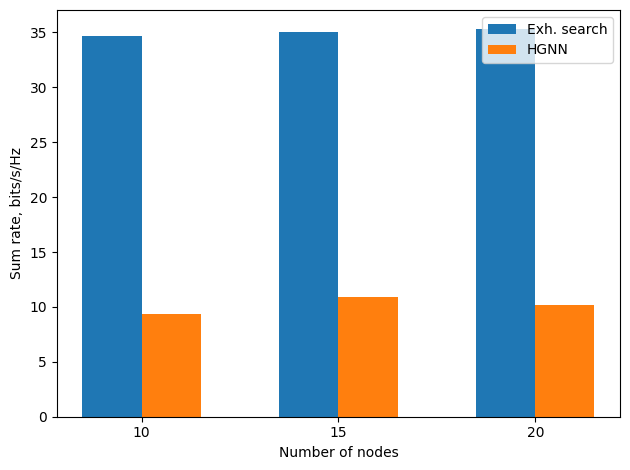

In [57]:
x = np.array(x)
width = 1.5

plt.bar(x - width/2, tput_exh, width, label="Exh. search")
plt.bar(x + width/2, tput_hgnn, width, label="HGNN")

# Add labels and legend
plt.xlabel("Number of nodes")
plt.ylabel("Sum rate, bits/s/Hz")
plt.xticks(x)
plt.legend()
plt.tight_layout()
# plt.savefig('sumrate_bar.jpg')
plt.show()

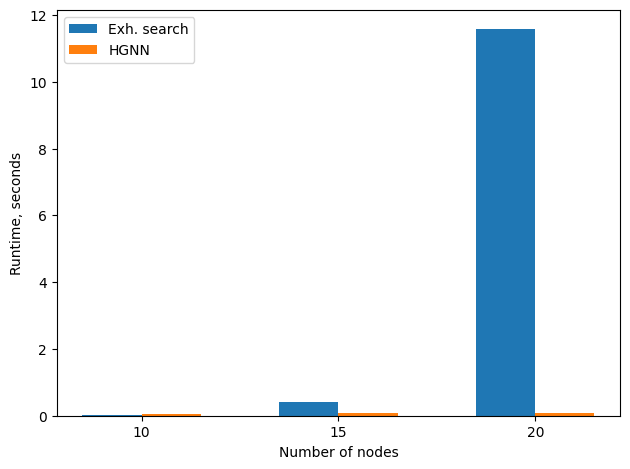

In [58]:
x = np.array(x)
width = 1.5

plt.bar(x - width/2, runtime_exh, width, label="Exh. search")
plt.bar(x + width/2, runtime_hgnn, width, label="HGNN")

# Add labels and legend
plt.xlabel("Number of nodes")
plt.ylabel("Runtime, seconds")
plt.xticks(x)
plt.legend()
plt.tight_layout()
# plt.savefig('runtime_bar.jpg')
plt.show()

## Convergence

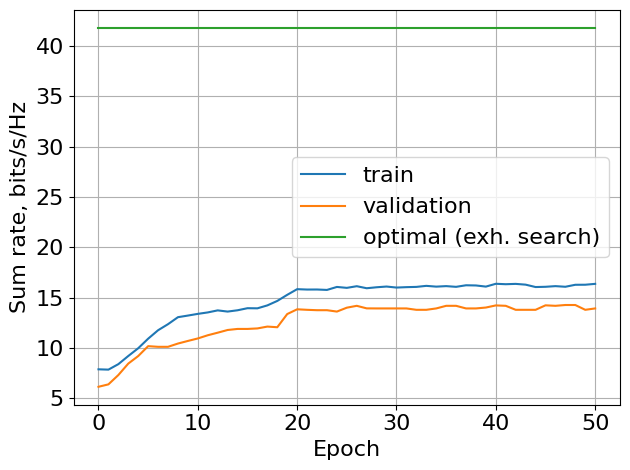

In [33]:
plt.plot(train_utility, label='train')
plt.plot(test_utility, label='validation')
plt.plot(np.full_like(train_utility, tput_optimal_mean), label='optimal (exh. search)')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Sum rate, bits/s/Hz', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
# plt.savefig('HGNN_train_xylim4000.jpg', bbox_inches='tight')

## Loss

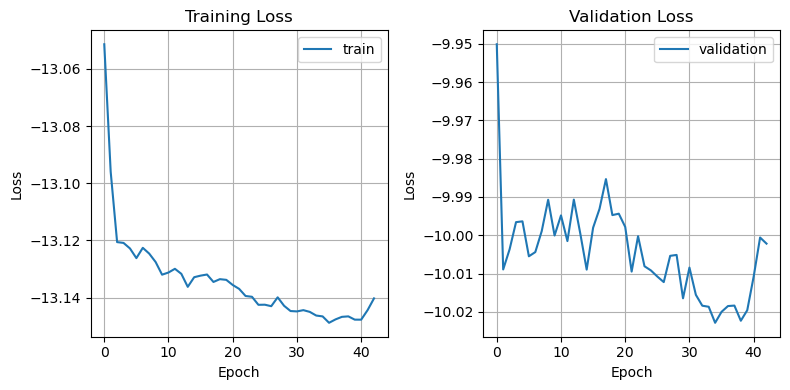

In [52]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot loss_train
axs[0].plot(loss_train, label='train')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plot loss_test
axs[1].plot(loss_test, label='validation')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

## Extensions

/tmp/ipykernel_13299/945646115.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Type', y='Value', data=df_utilities, palette='viridis', width=0.3)


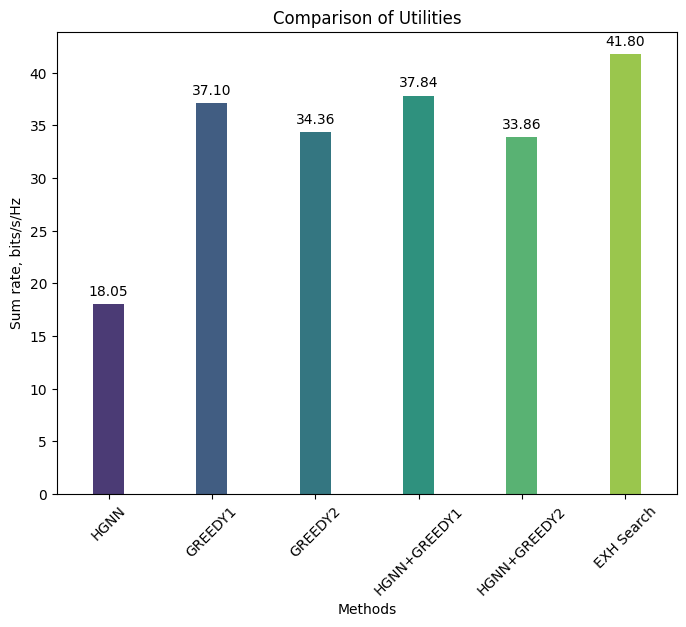

In [42]:
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd

# Data for plotting
utilities = {
    "HGNN": utility_base,
    'GREEDY1': utility_test_greedy1_mean,
    'GREEDY2': utility_test_greedy2_mean,
    "HGNN+GREEDY1": utility_test_wo_mean,
    "HGNN+GREEDY2": utility_test_w_mean,
    "EXH Search": exhaustive_utility_mean
}

# Create a DataFrame for seaborn
df_utilities = pd.DataFrame(list(utilities.items()), columns=['Type', 'Value'])

# Plotting with smaller size and numbers on top
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Type', y='Value', data=df_utilities, palette='viridis', width=0.3)
plt.title('Comparison of Utilities')
plt.xlabel('Methods')
plt.ylabel('Sum rate, bits/s/Hz')
plt.xticks(rotation=45)
plt.grid(False)

# Adding the values on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')
plt.savefig('tput_bar.jpg', bbox_inches='tight')
plt.show()